Importing the necessary libraries:


In [7]:
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tabulate import tabulate
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\costi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\costi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\costi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Setting up the directories

In [8]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_dir = os.path.join(base_dir, "src")
data_dir = os.path.join(base_dir, "data")
antivax_dir = os.path.join(data_dir, "ANTiVax")
labeled_dir = os.path.join(antivax_dir, "Labeled")

Creating the dataframe:

In [21]:
column_names = [
    'Tweet_ID', 'Username', 'Text', 'Retweets', 'Likes', 'Views',
    'Hashtags', 'Followers', 'Account_ID', 'Created_At', 'Extra'
]

tweets_df = pd.read_csv(
    f'{labeled_dir}/tweets.csv',
    encoding='utf-8',
    engine='python',
    quotechar='"',
    names=column_names,
    on_bad_lines='skip',
    header=0
)
labels_df = pd.read_csv(
    f'{labeled_dir}/VaxMisInfoData.csv',
    encoding='utf-8',
    engine='python',
    quotechar='"',
    on_bad_lines='skip',
    header=0
)
labels_df.rename(columns={'id': 'Tweet_ID', 'is_misinfo': 'label'}, inplace=True)

tweets_df['Tweet_ID'] = tweets_df['Tweet_ID'].astype(str)
labels_df['Tweet_ID'] = labels_df['Tweet_ID'].astype(str)

df_antivax = pd.merge(tweets_df, labels_df, on='Tweet_ID', how='inner')
df_antivax = df_antivax[['Tweet_ID', 'Text', 'Hashtags', 'label']]

print(df_antivax.count())

Tweet_ID    5177
Text        5177
Hashtags    1203
label       5177
dtype: int64


Label counts:

In [22]:
label_counts = df_antivax['label'].value_counts()
print(tabulate(label_counts.reset_index(), headers=['Label', 'Count'], tablefmt='psql'))

+----+---------+---------+
|    |   Label |   Count |
|----+---------+---------|
|  0 |       0 |    3387 |
|  1 |       1 |    1790 |
+----+---------+---------+


Text count distribution:

In [23]:
df_antivax['text_length'] = df_antivax['Text'].apply(lambda x: len(str(x).split()))
df_antivax['char_length'] = df_antivax['Text'].apply(lambda x: len(str(x)))

print(tabulate(df_antivax[['text_length','char_length']].describe(), headers='keys', tablefmt='psql'))

+-------+---------------+---------------+
|       |   text_length |   char_length |
|-------+---------------+---------------|
| count |     5177      |     5177      |
| mean  |       23.1041 |      158.773  |
| std   |       12.9509 |       94.8177 |
| min   |        2      |       12      |
| 25%   |       13      |       79      |
| 50%   |       19      |      136      |
| 75%   |       33      |      239      |
| max   |       61      |      673      |
+-------+---------------+---------------+


In [24]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

Extracting hashtags:

In [25]:
def extract_hashtags(text):
    return re.findall(r'#\w+', text.lower())

Cleaning the text:

In [26]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"http\S+|www\S+|url", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

In [27]:
df_antivax['extracted_hashtags'] = df_antivax['Text'].apply(extract_hashtags)
df_antivax['clean_text'] = df_antivax['Text'].apply(clean_text)

In [28]:
print(tabulate(df_antivax.head(), headers='keys', tablefmt='psql'))

+----+---------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+---------+---------------+---------------+----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |            Tweet_ID | Text                                                                                                                                                                                                                                                                                     |   Hashtags |   label |   text_length |   char_length | extracted_hashtags   | clean_text           

In [30]:
print(tabulate(df_antivax[['Text','clean_text']].head(), headers='keys', tablefmt='psql'))

+----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | Text                                                                                                                                                                                                                                                                                     | clean_text                                                                                                                                                                                           |
|----+----------------

All tweets word cloud:

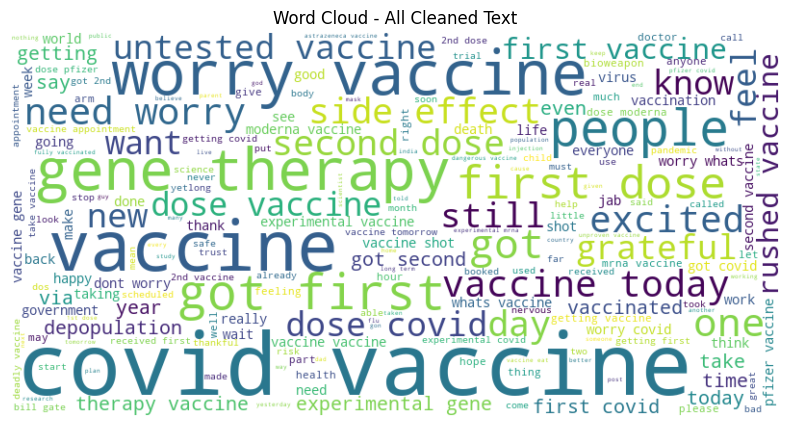

In [31]:
all_text = " ".join(df_antivax['clean_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - All Cleaned Text")
plt.show()

Word cloud for each label:


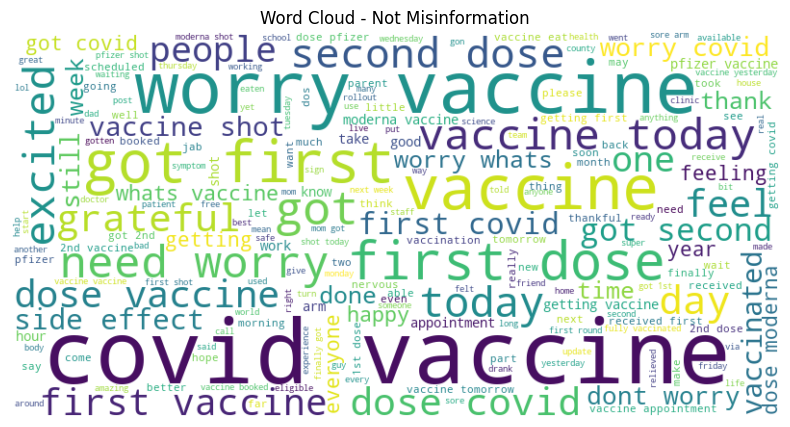

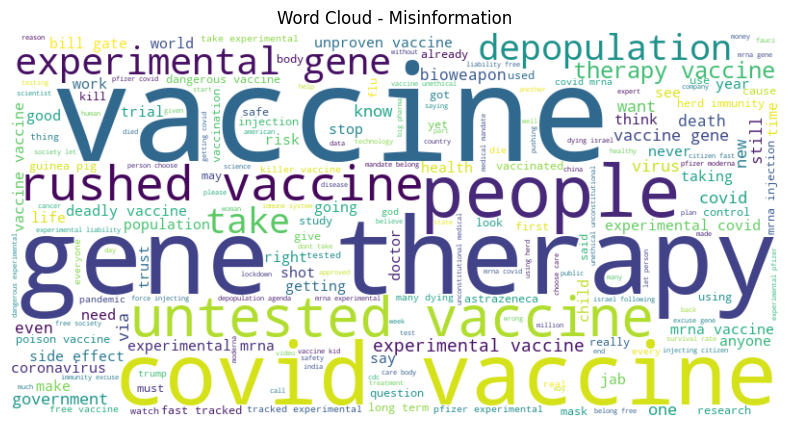

In [32]:
for label_value in df_antivax['label'].unique():
    subset = df_antivax[df_antivax['label'] == label_value]
    label_name = 'Misinformation' if label_value == 1 else 'Not Misinformation'
    label_text = " ".join(subset['clean_text'])

    wc = WordCloud(width=800, height=400, background_color='white').generate(label_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {label_name}")
    plt.show()

Word cloud for hashtags

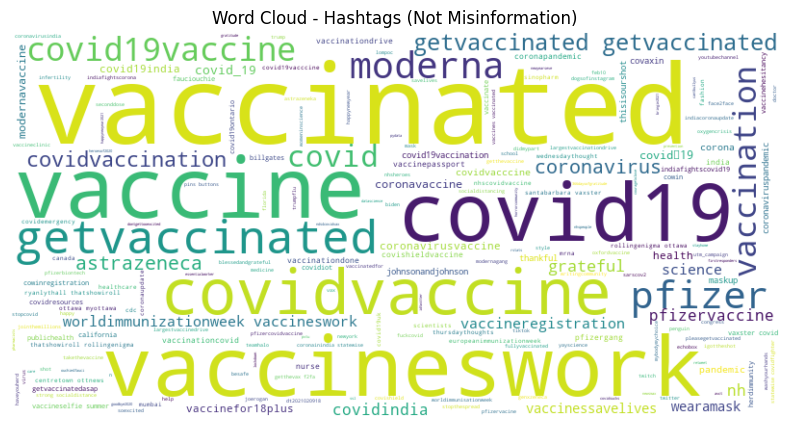

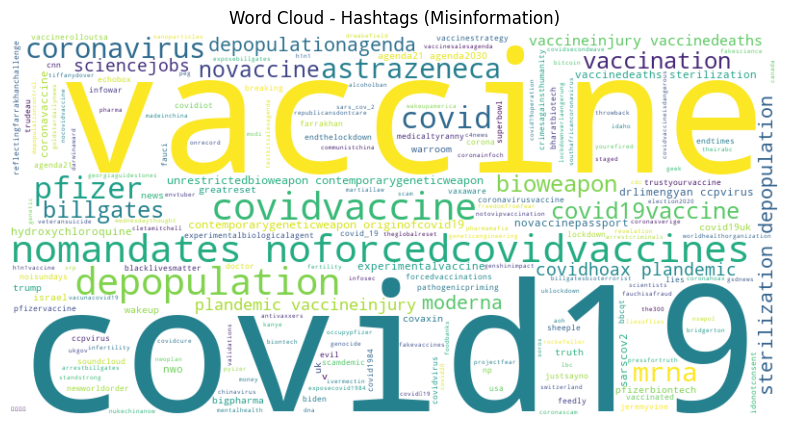

In [33]:
for label_value in df_antivax['label'].unique():
    label_name = 'Misinformation' if label_value == 1 else 'Not Misinformation'
    hashtags = df_antivax[df_antivax['label'] == label_value]['extracted_hashtags'].explode().dropna()
    hashtag_text = " ".join(hashtags)

    wc = WordCloud(width=800, height=400, background_color='white').generate(hashtag_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - Hashtags ({label_name})")
    plt.show()